# Test the pipeline with the Hungarian Kalman Filter (WKF).

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_kalman_filter_bis import HungarianKalmanFilterBis

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

In [ ]:

### Parameters
Dt = 0.005 # np.linspace(0.5, 5, 2) # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_p = 1 # np.linspace(1e-2, 2, 2) 
sigma_v = 0.8 # np.linspace(1e-2, 2, 2)
sigma_a = 0.8 # np.linspace(1e-2, 2, 2)

# Assuming no measurement noise
sigma_z = 0.5 # np.linspace(1e-6, 1, 5)

source = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00"
###

A = np.array([[1, Dt, Dt],
              [0, 1, Dt], 
              [0, 0, 1]]).astype(np.float64)
                        
H = np.array([[1, 0, 0]]).astype(np.float64)

Q = np.array([[sigma_p**2, 0, 0],
              [0, sigma_v**2, 0],
              [0, 0, sigma_a**2]])

R = np.array([[sigma_z**2]])

# Initial state covariance given all_x_0
P = np.zeros((3, 3))
P[1, 1] = 10
P[2, 2] = 10

image_folder_path = source + r"\signals"
GTs_folder_path = source + r"\ground_truth"
    
dataloader = create_dataloader(image_folder_path, GTs_folder_path, batch_size=4)

output_folder_path = source + r"\processed_HKF_bis"
os.makedirs(output_folder_path, exist_ok=True)
    
evaluate_filter(image_folder_path, GTs_folder_path, output_folder_path, HungarianKalmanFilterBis(A, H, Q, R), batch_size=25)

In [ ]:
### Parameters
Dts = [0.01, 0.005, 1] # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_ps = [0.0001, 1]
sigma_vs = [2.0, 0.8]
sigma_as = [0.0001, 0.8]
# Assuming no measurement noise
sigma_zs = [1e-6, 0.5]
###

sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44"]
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

min_RMSE = np.inf
best_params = {}
best_result = None

for Dt in tqdm(Dts, desc='Dt'):
    for sigma_p in sigma_ps:
        for sigma_v in sigma_vs:
            for sigma_z in sigma_zs:
                for sigma_a in sigma_as:
                    RMSE_temp = 0
                    RMSE_std_temp = 0
                    for source in sources:

                        A = np.array([[1, Dt, Dt],
                                    [0, 1, Dt], 
                                    [0, 0, 1]]).astype(np.float64)
                                                
                        H = np.array([[1, 0, 0]]).astype(np.float64)

                        Q = np.array([[sigma_p**2, 0, 0],
                                    [0, sigma_v**2, 0],
                                    [0, 0, sigma_a**2]])

                        R = np.array([[sigma_z**2]])

                        # Initial state covariance given all_x_0
                        P = np.zeros((3, 3))
                        P[1, 1] = 10
                        P[2, 2] = 10

                        image_folder_path = source + r"\signals"
                        GTs_folder_path = source + r"\ground_truth"
                            
                        dataloader = create_dataloader(image_folder_path, GTs_folder_path, batch_size=4)

                        output_folder_path = source + r"\processed_HKF_bis"
                        os.makedirs(output_folder_path, exist_ok=True)
    
                        RMSE_new, RMSE_std_new = evaluate_filter(image_folder_path, GTs_folder_path, output_folder_path, HungarianKalmanFilterBis(A, H, Q, R), batch_size=25, save=False)
                        RMSE_temp += RMSE_new
                        RMSE_std_temp += RMSE_std_new
                    
                    RMSE = RMSE_temp / len(sources)
                    RMSE_std = RMSE_std_temp / len(sources)
                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_RMSE_std = RMSE_std
                        best_params = {'Dt': Dt, 'sigma_p': sigma_p, 'sigma_v': sigma_v, 'sigma_a': sigma_a, 'sigma_z': sigma_z}

                        print('Best parameters:', best_params)
                        print('Minimum MSE:', min_RMSE)
                        print('Minimum MSE std:', min_RMSE_std)
                        
print('Best parameters:', best_params)
print('Minimum MSE:', min_RMSE)
print('Minimum MSE std:', min_RMSE_std)

Dt:   0%|          | 0/3 [00:00<?, ?it/s]
Best parameters: {'Dt': 0.01, 'sigma_p': 0.0001, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 1e-06}
Minimum MSE: 46.94492210745896
Minimum MSE std: 0.0
Best parameters: {'Dt': 0.01, 'sigma_p': 0.0001, 'sigma_v': 0.8, 'sigma_a': 0.0001, 'sigma_z': 1e-06}
Minimum MSE: 46.35099664818218
Minimum MSE std: 0.0
Dt:  33%|███▎      | 1/3 [10:18<20:37, 618.77s/it]
Best parameters: {'Dt': 0.005, 'sigma_p': 0.0001, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 1e-06}
Minimum MSE: 45.81654076834175
Minimum MSE std: 0.0
Dt:  67%|██████▋   | 2/3 [20:37<10:18, 618.58s/it]
Best parameters: {'Dt': 1, 'sigma_p': 0.0001, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 1e-06}
Minimum MSE: 45.436943628272836
Minimum MSE std: 0.0
Best parameters: {'Dt': 1, 'sigma_p': 1, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 0.5}
Minimum MSE: 42.57814910211738
Minimum MSE std: 0.0
Dt: 100%|██████████| 3/3 [30:56<00:00, 618.68s/it]
Best parameters: {'Dt': 1, 'sigma_p': 1, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 0.5}
Minimum MSE: 42.57814910211738
Minimum MSE std: 0.0


In [ ]:
### Parameters
Dts = [0.01, 0.1] # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_ps = [0.01]
sigma_vs = [0.0001]
sigma_as = [0.001]
# Assuming no measurement noise
sigma_zs = [0.01]
###

sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

for Dt in Dts:
    for sigma_p in sigma_ps:
        for sigma_v in sigma_vs:
            for sigma_z in sigma_zs:
                for sigma_a in sigma_as:
                    RMSE_temp = 0
                    RMSE_std_temp = 0
                    for source in tqdm(sources, desc='Sources'):

                        A = np.array([[1, Dt, Dt],
                                    [0, 1, Dt], 
                                    [0, 0, 1]]).astype(np.float64)
                                                
                        H = np.array([[1, 0, 0]]).astype(np.float64)

                        Q = np.array([[sigma_p**2, 0, 0],
                                    [0, sigma_v**2, 0],
                                    [0, 0, sigma_a**2]])

                        R = np.array([[sigma_z**2]])

                        # Initial state covariance given all_x_0
                        P = np.zeros((3, 3))
                        P[1, 1] = 10
                        P[2, 2] = 10

                        image_folder_path = source + r"\signals"
                        GTs_folder_path = source + r"\ground_truth"
                            
                        dataloader = create_dataloader(image_folder_path, GTs_folder_path, batch_size=4)

                        output_folder_path = source + r"\processed_HKF_bis"
                        os.makedirs(output_folder_path, exist_ok=True)
    
                        RMSE_new, RMSE_std_new = evaluate_filter(image_folder_path, GTs_folder_path, output_folder_path, HungarianKalmanFilterBis(A, H, Q, R), batch_size=25, step=1)
                        RMSE_temp += RMSE_new
                        RMSE_std_temp += RMSE_std_new
                    
                    RMSE = RMSE_temp / len(sources)
                    RMSE_std = RMSE_std_temp / len(sources)

                    print('RMSE:', RMSE)
                    print('RMSE std:', RMSE_std)

Sources:  50%|█████     | 5/10 [01:57<01:57, 23.52s/it]


KeyboardInterrupt: 

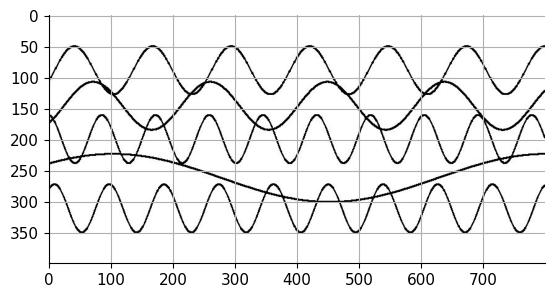

In [4]:
### Parameters
Dts = [0.03, 0.1] # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s
qs = [1, 0.1] # Process noise covariance matrix Q
# Assuming no measurement noise
sigma_zs = [1]
###

sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

for Dt in Dts:
    for sigma_z in sigma_zs:
        for q in qs:
            RMSE_temp = 0
            RMSE_std_temp = 0
            for source in tqdm(sources, desc='Sources'):

                A = np.array([[1, Dt, Dt],
                            [0, 1, Dt], 
                            [0, 0, 1]]).astype(np.float64)
                                                    
                H = np.array([[1, 0, 0]]).astype(np.float64)

                Q = q * np.array([[Dt**5/20, Dt**4/8, Dt**3/6],
                                [Dt**4/8, Dt**3/3, Dt**2/2],
                                [Dt**3/6, Dt**2/2, Dt]])

                R = np.array([[sigma_z**2]])

                # Initial state covariance given all_x_0
                P = np.zeros((3, 3))
                P[1, 1] = 10
                P[2, 2] = 10

                image_folder_path = source + r"\signals"
                GTs_folder_path = source + r"\ground_truth"
                            
                dataloader = create_dataloader(image_folder_path, GTs_folder_path, batch_size=4)

                output_folder_path = source + r"\processed_HKF_bis"
                os.makedirs(output_folder_path, exist_ok=True)
    
                RMSE_new, RMSE_std_new = evaluate_filter(image_folder_path, GTs_folder_path, output_folder_path, HungarianKalmanFilterBis(A, H, Q, R), batch_size=25, step=1)
                RMSE_temp += RMSE_new
                RMSE_std_temp += RMSE_std_new
                    
            RMSE = RMSE_temp / len(sources)
            RMSE_std = RMSE_std_temp / len(sources)

            print('RMSE:', RMSE)
            print('RMSE std:', RMSE_std)